# Library Imports

In [1]:
# Standard Libraries 
import pandas as pd
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# MongoDB
from pymongo import MongoClient

## Import Parameters from Topic_Extractor_Params.dat

In [162]:
fileObj = open('Topic_Extractor_Params.dat', mode='r')

topic_params = {}

for line in fileObj:
    line = line.strip()
    
    key_value = line.split('=')
    
    if len(key_value) == 2:
        topic_params[key_value[0].strip()] = key_value[1].strip()

## Assign Params from .dat ##

lowercase         = bool(topic_params['All Lowercase'])
no_accents        = bool(topic_params['Remove Accents'])
no_contradictions = bool(topic_params['Remove Contradictions'])
no_emails         = bool(topic_params['Remove Emails'])
no_newline        = bool(topic_params['Remove Newline'])
no_punctuation    = bool(topic_params['Remove Punctuation'])
no_currency       = bool(topic_params['Replace Currency'])

added_stop_words  = topic_params['Added Stop Words'].split(' ')

n_hours           = int(topic_params['Time Frame in Hours'])
red_or_blue       = str(topic_params['Red or Blue'])
n_topics          = int(topic_params['Number of Topics'])
model             = str(topic_params['Model'])

## Import Database from Mongo

In [3]:
client = MongoClient(host='34.215.237.208', port=27016)

db = client.Politiprocess

collection = db.reddit_posts

In [4]:
from datetime import datetime, timedelta
import pytz

In [38]:
dt = datetime.utcnow() - timedelta(hours=24)
df = pd.DataFrame(list(collection.find({'is article': True , 'date': {'$gt': dt}})))

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 16 columns):
_id                  62 non-null object
article title        62 non-null object
author               36 non-null object
comments             62 non-null object
date                 62 non-null datetime64[ns]
domain               62 non-null object
is article           62 non-null bool
keywords             62 non-null object
link                 62 non-null object
post title           62 non-null object
score                62 non-null int64
subreddit            62 non-null object
target               62 non-null bool
text                 62 non-null object
title objectivity    62 non-null float64
title polarity       62 non-null float64
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(10)
memory usage: 7.0+ KB


## Preprocessing

In [40]:
import textacy
import spacy

In [134]:
cleaned = [] 
for x in range(len(df)):
    cleaned.append(textacy.preprocess.preprocess_text(df.text[x],
                                                    fix_unicode=True,
                                                    lowercase=False,
                                                    no_punct=True,
                                                    no_contractions=True,
                                                    no_currency_symbols=True,
                                                    no_emails=True,
                                                    no_accents=True,
                                                   ).replace('\n', ' '))

df['cleaned'] = cleaned
cleaned = []

In [135]:
df.cleaned[0]

'A new report released on Wednesday revealed that approximately half of Californias population supports President Donald Trumps travel ban and increasing the number of deportations carried out by federal immigration authorities The survey conducted by leftleaning UC Berkeleys Haas Institute for a Fair and Inclusive Society found that support for the Trump administrations agenda was strong even in the states most farleft areas The Daily Democrat reports About 24 percent of the surveys participants said its very important for the US to increase deportations of undocumented immigrants while 35 percent said its somewhat important according to the poll That viewpoint even held true in the Bay Area where 25 percent of those surveyed said increasing deportations is very important and 35 percent said its somewhat important And about 49 percent of Californians support temporarily banning people from Muslimmajority countries according to the poll In the Bay Area 44 percent of residents support t

In [42]:
nlp = spacy.load('en_core_web_md')

In [43]:
def remove_whitespace_entities(doc):
    doc.ents = [e for e in doc.ents if not e.text.isspace()]
    return doc

nlp.add_pipe(remove_whitespace_entities, after='parser')
nlp.pipeline

[('tagger', <spacy.pipeline.Tagger at 0x7fef65a79550>),
 ('parser', <spacy.pipeline.DependencyParser at 0x7fef65b74f10>),
 ('remove_whitespace_entities',
  <function __main__.remove_whitespace_entities>),
 ('ner', <spacy.pipeline.EntityRecognizer at 0x7fef65a39620>)]

In [44]:
extra_stop_words = ["device medium caption", "medium", "caption", "playback", "unsupported", 
 "said", "week", "him", "you", "You", "what", "she", "them", "They", "they", "who", "News4jax", "News4Jax"]

for word in extra_stop_words:
    nlp.vocab[word].is_stop = True

In [156]:
' '.join(extra_stop_words)

'device medium caption medium caption playback unsupported said week him you You what she them They they who News4jax News4Jax'

In [45]:
chunks_list = []

for cleaned in df.cleaned:
    
    doc = nlp(str(cleaned))
    
    chunks = []
    
    for span in doc.noun_chunks:
        if len(span) == 1:
            if span[0].is_stop or len(span[0]) <= 2:
                continue
            else:
                chunks.append(span.text)
                continue
        else:
            chunks.append(span.text)
    
    for ent in doc.ents:
        if ent.label_ in ['PERSON', 'GPE', 'ORG', 'NORP']:
            chunks.append(ent.text)
            
    chunks_list.append(chunks)
    
df['chunks'] = chunks_list
chunks_list = []

In [114]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', smooth_idf=False, sublinear_tf=True,
                        min_df=0, max_df=.6, max_n_terms=None)

# doc_term_matrix = vectorizer.fit_transform(df.chunks[(df.target == True)])
doc_term_matrix = vectorizer.fit_transform(df.chunks[(df.target == False)])

topic 0 : Starbucks   Demby   McMillan Cottom   Harris   Bouie   white people   Tressie   the police   black people   night
topic 1 : Brazil   Bolsonaro   Eduardo Bolsonaro   Roraima   Legend   Boa Vista   Photograph   Vijay Rangarajan   Guilherme Boulos   Wellington Vasconcellos
topic 2 : Cohen   the FBI raid   the president   New York   FBI   Mueller   Michael Cohen   Russia   BuzzFeed   South Florida
topic 3 : Americans   Perlstein   lies   Obama   Newsweek   the reality   Sarah Palin   church   Wilson   liars
topic 4 : tax reform   NRCC   Republican incumbents   the NRCC   Iowa   Democratic challengers   last year   Minnesota   Jason Lewis   LaCivita
topic 5 : Haley   Pence   the White House   Russia   the United Nations   Lerner   her   She   State   White House
topic 6 : Facebook   GDPR   EU   Ireland   Canada   Reuters   the United States   Facebook Inc   European   Irish
topic 7 : Senate   Democrats   the Senate   Dent   Republicans   McConnell   Democratic   Republican   House

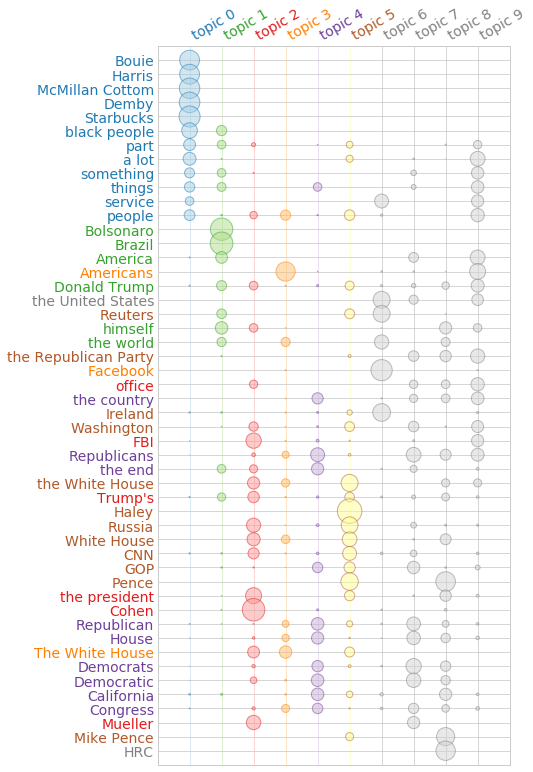

In [116]:
model = textacy.tm.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)

topics_string = ""

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    topics_string += ' '.join(top_terms) + ' '
    print('topic', topic_idx, ':', '   '.join(top_terms))
    
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=50, sort_terms_by='seriation')

In [100]:
from wordcloud import WordCloud

In [101]:
topics_string

'GOP A renewed GOP Republicans the future Washington the Republican Party Americans Republican Party Trump The Republican Party Imran Minhas Pakistan Haji Awans the Awans TheDCNF Pakistani Rehman Malik Malik Chinese Illinois UIUC party cells a group Xi Chile Spain Italy Connecticut Weinstein Harvey Hollywood Ben Harvey Weinstein Brad Hillary Bill Michelle course North Korea Moon Kim Pyongyang South Korea Trump Korean Japan Pompeo U.S. Liberty Patriots our flag American Patriots a friend Concord Lexington Lexington Green Jefferson Thomas Jefferson Peterson SNAP Conaway The legislation the provision the bill food stamps poverty House GOP Philo ESPN A&E MTV Viacom CNN Disney CMT History USD16 DeSantis Comey McCabe Gaetz FBI Ariz. Andrew McCabe Loretta Lynch Jeff Sessions Congress Manafort Mueller Dreeben Rosenstein prosecutors Alexandria Jackson Russian Russia the reasons '

In [102]:
wordcloud = WordCloud().generate(topics_string)

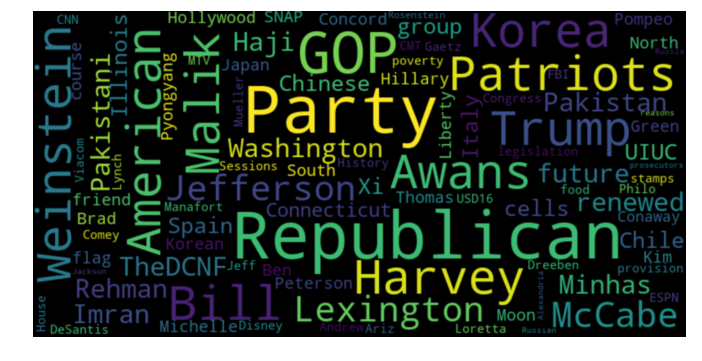

In [107]:
wordcloud = WordCloud(max_font_size=80, width = 800, height=400).generate(topics_string)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bicubic")
plt.axis("off")
plt.show()

In [ ]:
len(vectorizer.id_to_term)

In [ ]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4],
                   topics=-1,  n_terms=40, sort_terms_by='seriation')

In [ ]:
for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

In [ ]:
for x in doc:
    x.ent_iob_

In [ ]:
for x in doc:
    print()

In [ ]:
STOP_WORDS

In [ ]:
for x in doc.noun_chunks:
    if x.text.lower() not in STOP_WORDS:
        print(x)

In [ ]:
texts = [] 
for x in range(len(df)):
    texts.append(textacy.preprocess.preprocess_text(df.text[x],
                                                    fix_unicode=False,
                                                    lowercase=True,
                                                    no_punct=True,
                                                    no_contractions=True,
                                                    no_currency_symbols=True,
                                                    no_emails=True,
                                                    no_accents=True,
                                                   ))

df.cleaned = texts
texts = []

In [ ]:
from sklearn.feature_extraction import text

stop_words = text.ENGLISH_STOP_WORDS.union(["device medium caption", 
                                            "medium", "caption", 
                                            "playback", "unsupported",
                                            "said", " 's", "'s","", " ", "  ","''", "week"])

In [ ]:
for term in stop_words:
    STOP_WORDS.add(term)

In [ ]:
corpus = textacy.corpus.Corpus(lang='en', texts=list(df.cleaned))

In [ ]:
for x in corpus[0].tokens:
    print(x.is_stop)

In [ ]:
terms_list = (docs.to_terms_list(ngrams=(1,2,3), named_entities=False, as_strings=True, filter_stops=True, filter_punct=True) for docs in corpus)

In [ ]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=False, smooth_idf=True, 
                        min_df=.01, max_df=.99, max_n_terms=None)

doc_term_matrix = vectorizer.fit_transform(terms_list)
doc_term_matrix.shape

In [ ]:
model = textacy.tm.TopicModel('nmf', n_topics=10)
model.fit(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print(top_terms)

In [ ]:
model.termite_plot(doc_term_matrix, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=100, sort_terms_by='seriation')

In [ ]:
tfidf_vectorizer = TfidfVectorizer(ngram_range = (1,3), min_df = 2, stop_words = stop_words, max_features=None)

In [ ]:
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df['cleaned'])

In [ ]:
document_term_matrix_df = pd.DataFrame(document_term_matrix_sps.toarray(),
                                       index=df.index,
                                       columns=tfidf_vectorizer.get_feature_names())

In [ ]:
len(tfidf_vectorizer.get_feature_names())

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
lda = LatentDirichletAllocation(n_components=20, n_jobs=-1, max_iter=10, learning_method='batch')

In [ ]:
lda_matrix = lda.fit_transform(document_term_matrix_df)

In [ ]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [ ]:
print_top_words(lda, tfidf_vectorizer.get_feature_names(), 10)

## LSA

In [ ]:
n_components = 10
SVD = TruncatedSVD(n_components)
component_names = ["component_"+str(i+1) for i in range(n_components)]

In [ ]:
svd_matrix = SVD.fit_transform(document_term_matrix_df)

In [ ]:
latent_semantic_analysis = pd.DataFrame(svd_matrix,
                                        index=document_term_matrix_df.index,
                                        columns=component_names)

In [ ]:
latent_semantic_analysis

In [ ]:
vocabulary_loadings = pd.DataFrame(SVD.components_,
                                   index=component_names,
                                   columns=tfidf_vectorizer.get_feature_names()).T

In [ ]:
vocabulary_loadings.sort_values('component_5', 0, ascending=False)

In [ ]:
for component in vocabulary_loadings:
    print(component + ' - ' + vocabulary_loadings[component].idxmax())

In [ ]:
n_components = 100
X = list(range(5, n_components))
e_v_s = []

tfidf_vectorizer = TfidfVectorizer(min_df = 5, stop_words = stop_words)
document_term_matrix_sps = tfidf_vectorizer.fit_transform(df['cleaned'])

for x in range(5,n_components):
    n_components = x
    SVD = TruncatedSVD(n_components)
    svd_matrix = SVD.fit_transform(document_term_matrix_df)
    e_v_s.append(SVD.explained_variance_ratio_.sum())
    
plt.plot(X, e_v_s)

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
X = latent_semantic_analysis.drop('target', axis=1)
y = latent_semantic_analysis['target']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = .1,)

In [ ]:
ks = list(range(1,25))
train_accuracies = []
test_accuracies = []

for k in ks:
    knc = KNeighborsClassifier(n_neighbors=k, n_jobs = -1)
    knc.fit(X_train, y_train)
    train_score = knc.score(X_train, y_train)
    test_score = knc.score(X_test, y_test)
    train_accuracies.append(train_score)
    test_accuracies.append(test_score)

In [ ]:
plt.plot(ks, train_accuracies, c='g', label='train')
plt.plot(ks, test_accuracies, c='b', label='test')
plt.axvline(np.argmax(test_accuracies)+1, label='optimal_k')
plt.legend()

In [ ]:
knc = KNeighborsClassifier(n_neighbors=np.argmax(test_accuracies)+1, n_jobs = -1)
knc.fit(X_train, y_train)
train_score = knc.score(X_train, y_train)
test_score = knc.score(X_test, y_test)
print(train_score, test_score)

## Logistic Regression

In [ ]:
log = LogisticRegression(C=100)
log.fit(X_train,y_train)

In [ ]:
log.score(X_train,y_train), log.score(X_test,y_test)

# Spacy

In [ ]:
doc = nlp(article_title_list[0])
doc.is_parsed

In [ ]:
import spacy
from collections import Counter
nlp = spacy.load('en')

# all tokens that arent stop words or punctuations
words = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True]

# noun tokens that arent stop words or punctuations
nouns = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common(5)

# five most common noun tokens
noun_freq = Counter(nouns)
common_nouns = noun_freq.most_common(5)

In [ ]:
# all tokens that arent stop words or punctuations
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

In [ ]:
words

In [ ]:
# noun tokens that arent stop words or punctuations
nouns = [token.text for token in self.doc if token.is_stop != True and token.is_punct != True and token.pos_ == "NOUN"]

In [ ]:
for x in doc.doc:
    print(x)

In [ ]:
num = 0
# doc = nlp(article_text_list[0])
for num, entity in enumerate(doc.ents):
    print(f'Entity {num + 1}', entity, '-', entity.label_)

In [ ]:
def punct_space(token):
    return token.is_punct or token.is_space

def article_reader(df):
    for article in df.cleaned:
        yield article.replace("\n\n", "\n")

def lemmatized_sentence_corpus(document):
    for parsed_article in nlp.pipe(document, batch_size = 100000, n_threads = 4):
        
        for sent in parsed_article.sents:
            yield ' '.join([token.lemma_ for token in sent if not punct_space(token)])

In [ ]:
for sent in lemmatized_sentence_corpus(article_reader(df)):
    print(sent)

# Textacy

In [ ]:
import spacy
import textacy
from spacy import displacy

In [ ]:
df = list(collection.find({'is article': True}, {'_id': 0, 'comments':0}))

In [ ]:
texts = []
metadatas = [] 
for x in range(len(df)):
    texts.append(textacy.preprocess.preprocess_text(df[x].pop('text'),
                                                    fix_unicode=True,
                                                    no_contractions=True,
                                                    no_currency_symbols=True,
                                                    no_emails=True,
                                                    no_numbers=True,
                                                   ))
    metadatas.append(df[x])
df = []

In [ ]:
corpus = textacy.corpus.Corpus(lang='en', texts=texts, metadatas=metadatas)

In [ ]:
nlp = spacy.load(name='en')

In [ ]:
doc = corpus[1]

In [ ]:
doc_nlp = nlp(doc.text)

In [ ]:
displacy.render(doc_nlp, style='ent', jupyter=True)

In [ ]:
terms_list = (docs.to_terms_list(ngrams=3, normalize='lemma', lemmatize=True,
                                 named_entities=True, as_strings=True, filter_stops=True)for docs in corpus)

In [ ]:
terms_list

In [ ]:
vectorizer = textacy.vsm.Vectorizer(weighting='tfidf', normalize=False, smooth_idf=True, 
                        min_df=.01, max_df=.99, max_n_terms=1000)

doc_term_matrix = vectorizer.fit_transform(terms_list)

In [ ]:
from sklearn.decomposition import NMF

In [ ]:
vectorizer.id_to_term

In [ ]:
model = textacy.tm.TopicModel('nmf', n_topics=5)
model.fit(doc_term_matrix)

for topic_idx, top_terms in model.top_topic_terms(vectorizer.id_to_term, top_n=10):
    print('topic', topic_idx, ':', '   '.join(top_terms))

In [ ]:
model.termite_plot(vocabulary_loadings, vectorizer.id_to_term, highlight_topics=[0,1,2,3,4,5],
                   topics=-1,  n_terms=100, sort_terms_by='seriation')

## Gensim

In [ ]:
stopWords = set(stopwords.words('english'))

In [ ]:
corpus = 

In [ ]:
tfidf = models.TfidfModel(corpus)

# TextBlob

In [ ]:
for article_title in df['article title']:
    print(article_title, TextBlob(article_title).sentiment, TextBlob(article_title).np_counts)

In [ ]:
all_titles = ""
for article_title in df['article title']:
    all_titles += '. ' + article_title

In [ ]:
all_titles

In [ ]:
article_title = TextBlob(df['article title'][1])
article_title

In [ ]:
all_titles_blob = TextBlob(all_titles)

In [ ]:
for sentence in all_titles_blob.sentences:
    print(sentence, sentence.np_counts, sentence.sentiment)

In [ ]:
for text in red_topic_list['post title']:
    blob = TextBlob(text)
    print(text, blob.sentiment_assessments, "\n")

In [ ]:
# NLP Libraries
from nltk.corpus import stopwords

import textacy

import spacy

from textblob import TextBlob

from gensim.corpora import Dictionary, MmCorpus
from gensim.models.ldamulticore import LdaMulticore

In [ ]:
# Visualization
import matplotlib.pyplot as plt
from spacy import displacy
import pyLDAvis
import pyLDAvis.gensim
import warnings

%matplotlib inline